In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_probability_alive_matrix
from sklearn.metrics import silhouette_score
import datetime as dt

In [127]:
df = pd.read_csv(r'F:\Download\OnlineRetail.csv\OnlineRetail.csv', encoding='latin1')
df['Monetary'] = df['Quantity'] * df['UnitPrice']
df['CustomerID'] = df['CustomerID'].apply(lambda x: str(x).replace('.0', '') if pd.notna(x) else x)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df = df[df['Quantity'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531285 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531285 non-null  object        
 1   StockCode    531285 non-null  object        
 2   Description  530693 non-null  object        
 3   Quantity     531285 non-null  int64         
 4   InvoiceDate  531285 non-null  datetime64[ns]
 5   UnitPrice    531285 non-null  float64       
 6   CustomerID   397924 non-null  object        
 7   Country      531285 non-null  object        
 8   Monetary     531285 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 40.5+ MB


In [629]:
df_clients = df.copy()
df_clients['Hour'] = df_clients['InvoiceDate'].dt.hour
df_clients['Period'] = pd.cut(df_clients['Hour'], bins=[0, 12, 18, 24], labels=['Day', 'Afternoon', 'Night'], include_lowest=True)
df_clients['InvoiceDate'] = pd.to_datetime(df_clients['InvoiceDate'], format='%d-%m-%Y %H:%M').dt.date
df_clients = df_clients.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Period'], observed=True)['Monetary'].sum().reset_index(name='Monetary')
df_clients['InvoiceDate'] = pd.to_datetime(df_clients['InvoiceDate'], format='%d-%m-%Y')
df_clients                                      

,CustomerID,InvoiceNo,InvoiceDate,Period,Monetary
0,12346,541431,2011-01-18,Day,77183.60
1,12347,537626,2010-12-07,Afternoon,711.79
2,12347,542237,2011-01-26,Afternoon,475.39
3,12347,549222,2011-04-07,Day,636.25
4,12347,556201,2011-06-09,Afternoon,382.52
...,...,...,...,...,...
18531,18283,579673,2011-11-30,Day,223.61
18532,18283,580872,2011-12-06,Day,208.00
18533,18287,554065,2011-05-22,Day,765.28
18534,18287,570715,2011-10-12,Day,1001.32


In [129]:
df_clients.groupby(['Period'], observed=True)['CustomerID'].count().reset_index()

,Period,CustomerID
0,Day,9611
1,Afternoon,8763
2,Night,162


In [494]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
df_rfmt = summary_data_from_transaction_data(transactions = df_clients, 
                                         customer_id_col = 'CustomerID', 
                                         datetime_col = 'InvoiceDate', 
                                         monetary_value_col = 'Monetary')
df_rfmt

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
...,...,...,...,...
18280,0.0,0.0,277.0,0.000000
18281,0.0,0.0,180.0,0.000000
18282,1.0,119.0,126.0,77.840000


In [495]:
# size of the data 
diff_time = df_clients['InvoiceDate'].max() - df_clients['InvoiceDate'].min() 
diff_time

datetime.timedelta(days=373)

In [496]:
# Getting the ending date of the calibration period. 
end_date_cal = df_clients['InvoiceDate'].min() + dt.timedelta(days=300)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=300))

In [497]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df_clients, 
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,252.0,0.0,73.0
12347,4.0,238.0,294.0,2.0,73.0
12348,3.0,283.0,285.0,0.0,73.0
12350,0.0,0.0,237.0,0.0,73.0
12352,4.0,216.0,223.0,2.0,73.0
...,...,...,...,...,...
18280,0.0,0.0,204.0,0.0,73.0
18281,0.0,0.0,107.0,0.0,73.0
18282,0.0,0.0,53.0,1.0,73.0


In [498]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = ParetoNBDFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values. 
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results 
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)

resl[resl['rmse_score'] == resl['rmse_score'].min()]

,rmse_score,L2 coefs
1,1.329342,0.4


In [499]:
# Fitting the model using the calibration dataset.
model = ParetoNBDFitter(penalizer_coef=0.9)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

<lifetimes.ParetoNBDFitter: fitted with 3572 subjects, alpha: 68.87, beta: 1328.62, r: 0.76, s: 0.00>

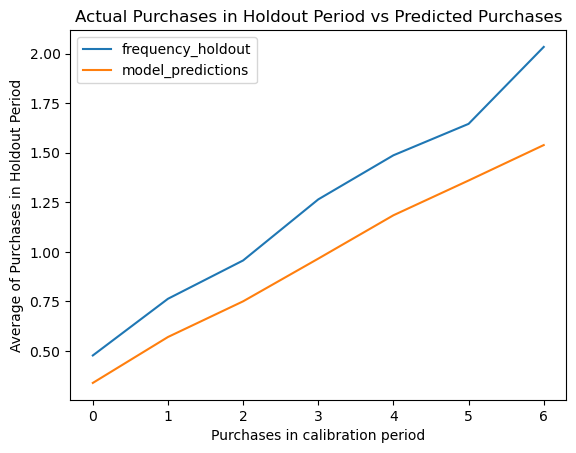

In [500]:
plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal)
plt.show()

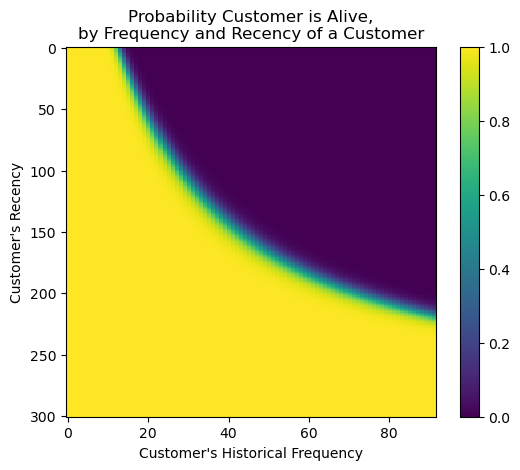

In [501]:
plot_probability_alive_matrix(model)
plt.show()

In [502]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(30, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347,6.0,365.0,367.0,599.701667,0.465134
12348,3.0,283.0,358.0,301.480000,0.264102
12352,6.0,260.0,296.0,368.256667,0.555645
12356,2.0,303.0,325.0,269.905000,0.210062
12358,1.0,149.0,150.0,683.200000,0.240952
...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,0.548602
18273,2.0,255.0,257.0,76.500000,0.253896
18282,1.0,119.0,126.0,77.840000,0.270628


In [503]:
# Fitting the GammaGamma model 
gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [504]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
CustomerID,,,,,,
12347,6.0,365.0,367.0,599.701667,0.465134,569.988807
12348,3.0,283.0,358.0,301.480000,0.264102,333.762672
12352,6.0,260.0,296.0,368.256667,0.555645,376.166864
12356,2.0,303.0,325.0,269.905000,0.210062,324.008941
12358,1.0,149.0,150.0,683.200000,0.240952,539.930643
...,...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,0.548602,474.369525
18273,2.0,255.0,257.0,76.500000,0.253896,201.781295
18282,1.0,119.0,126.0,77.840000,0.270628,260.275833


In [505]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 1,# In months 
    )
df_rfmt 

c:\Users\pcday\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.465134,569.988807,262.496105
12348,3.0,283.0,358.0,301.480000,0.264102,333.762672,87.274606
12352,6.0,260.0,296.0,368.256667,0.555645,376.166864,206.945777
12356,2.0,303.0,325.0,269.905000,0.210062,324.008941,67.387975
12358,1.0,149.0,150.0,683.200000,0.240952,539.930643,128.809101
...,...,...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,0.548602,474.369525,257.663216
18273,2.0,255.0,257.0,76.500000,0.253896,201.781295,50.724251
18282,1.0,119.0,126.0,77.840000,0.270628,260.275833,69.740414


In [506]:
df_rfmt[df_rfmt['CLV'] == 0]

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,


In [507]:
rows_with_nan_clv = df_rfmt[df_rfmt['CLV'].isna()]
rows_with_nan_clv

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,


In [508]:
def quartile(column):
    df_rfmt[column + '_score'] = pd.qcut(df_rfmt[column], q=4, labels = ['1', '2', '3', '4'],duplicates='drop')
    return df_rfmt

quartile('CLV')

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,CLV_score
CustomerID,,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.465134,569.988807,262.496105,4
12348,3.0,283.0,358.0,301.480000,0.264102,333.762672,87.274606,2
12352,6.0,260.0,296.0,368.256667,0.555645,376.166864,206.945777,3
12356,2.0,303.0,325.0,269.905000,0.210062,324.008941,67.387975,1
12358,1.0,149.0,150.0,683.200000,0.240952,539.930643,128.809101,3
...,...,...,...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,0.548602,474.369525,257.663216,4
18273,2.0,255.0,257.0,76.500000,0.253896,201.781295,50.724251,1
18282,1.0,119.0,126.0,77.840000,0.270628,260.275833,69.740414,1


In [578]:
def outliers_iqr_multi_columns(df, columns, factor=1.5):
    """
    Remove outliers from multiple columns of a DataFrame using the Interquartile Range (IQR) method.

    Parameters:
        df (DataFrame): The input DataFrame.
        columns (list): List of column names for which outliers are to be removed.
        factor (float): The multiplier to determine the outlier threshold.

    Returns:
        DataFrame: The DataFrame with outliers removed.
        DataFrame: The DataFrame containing the outlier rows.
    """
    filtered_data = df.copy()
    outlier_data = pd.DataFrame()
    
    for column in columns:
        Q1 = filtered_data[column].quantile(0.25)
        Q3 = filtered_data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        outliers = filtered_data[(filtered_data[column] < lower_bound) | (filtered_data[column] > upper_bound)]
        outlier_data = pd.concat([outlier_data, outliers])
        
        filtered_data = filtered_data[(filtered_data[column] >= lower_bound) & (filtered_data[column] <= upper_bound)]
    
    return filtered_data, outlier_data

In [727]:
df_treated = outliers_iqr_multi_columns(df_rfmt, ['frequency', 'recency', 'monetary_value'])[0]
df_treated

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,CLV_score,PCA1,PCA2,Cluster
CustomerID,,,,,,,,,,,
12347,6.0,365.0,367.0,599.701667,0.465134,569.988807,262.496105,4,1.691890,-0.012362,1
12348,3.0,283.0,358.0,301.480000,0.264102,333.762672,87.274606,2,0.965932,-0.099564,1
12352,6.0,260.0,296.0,368.256667,0.555645,376.166864,206.945777,3,0.646694,-0.047852,1
12356,2.0,303.0,325.0,269.905000,0.210062,324.008941,67.387975,1,0.817018,-0.103784,1
12358,1.0,149.0,150.0,683.200000,0.240952,539.930643,128.809101,3,-1.207004,0.096147,0
...,...,...,...,...,...,...,...,...,...,...,...
18270,1.0,228.0,266.0,171.200000,0.157484,303.404836,47.308445,1,-0.043623,-0.108695,1
18272,5.0,244.0,246.0,487.752000,0.548602,474.369525,257.663216,4,0.185642,0.004331,1
18273,2.0,255.0,257.0,76.500000,0.253896,201.781295,50.724251,1,0.122060,-0.135467,1


In [728]:
df_outlier = outliers_iqr_multi_columns(df_rfmt, ['frequency', 'recency', 'monetary_value'])[1]
df_outlier

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,CLV_score,PCA1,PCA2,Cluster
CustomerID,,,,,,,,,,,
12415,15.0,313.0,337.0,7860.210000,1.164758,7323.918818,8446.131391,4,1.828723,2.264079,1
12431,13.0,338.0,373.0,471.476923,0.934075,466.990870,431.885418,4,2.018535,-0.031213,1
12437,14.0,330.0,331.0,325.622143,1.107210,332.633772,364.648989,4,1.779108,-0.058787,1
12471,19.0,362.0,364.0,919.138947,1.369328,890.131707,1206.814156,4,2.490231,0.123158,1
12474,16.0,312.0,329.0,445.399375,1.263580,443.466815,554.807810,4,1.790939,-0.013557,1
...,...,...,...,...,...,...,...,...,...,...,...
18092,9.0,363.0,365.0,842.504444,0.674715,793.740673,530.246288,4,1.861620,0.071558,1
18139,1.0,1.0,18.0,1825.740000,0.607095,1067.743525,641.804033,4,-2.865421,0.508716,0
18202,1.0,112.0,311.0,911.260000,0.138828,645.286259,88.697075,2,-0.439749,0.118711,0


In [763]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_treated[['frequency', 'recency', 'T', 'monetary_value']])

# Perform PCA with minimun of 70% Explaneid Variance
pca = PCA(0.7)
pca.fit(scaled_data)
pca_values = pca.transform(scaled_data)

In [764]:
#original_data = pca.inverse_transform(scaled_data)
#original_data

In [765]:
df_treated['PCA1'] = x1 = pca_values[:, 0]
df_treated['PCA2'] = x2 = pca_values[:, 1]

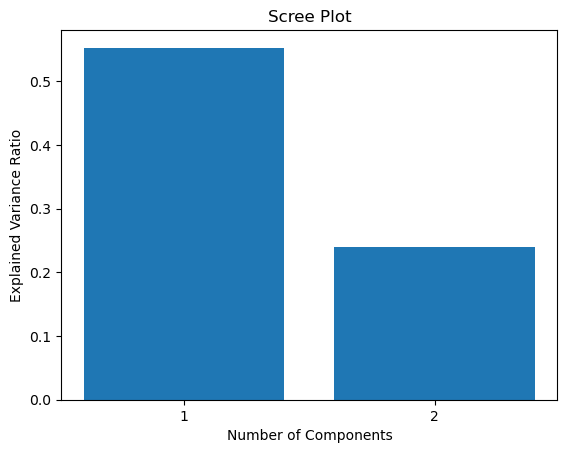

In [767]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

# Plot the scree plot
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

In [781]:
correlation_matrix = df_treated[['frequency', 'recency', 'T', 'monetary_value', 'CLV', 'PCA1', 'PCA2']].corr()
print("\nCorrelation Matrix:")
correlation_matrix


Correlation Matrix:


,frequency,recency,T,monetary_value,CLV,PCA1,PCA2
frequency,1.000000,0.563308,0.372701,0.156678,0.604332,7.324238e-01,2.674940e-02
recency,0.563308,1.000000,0.781421,0.173318,0.053172,9.308033e-01,-1.174392e-01
T,0.372701,0.781421,1.000000,0.095774,-0.219894,8.492568e-01,-2.232678e-01
monetary_value,0.156678,0.173318,0.095774,1.000000,0.531925,2.951025e-01,9.465610e-01
CLV,0.604332,0.053172,-0.219894,0.531925,1.000000,2.090963e-01,5.857507e-01
PCA1,0.732424,0.930803,0.849257,0.295103,0.209096,1.000000e+00,6.927947e-17
PCA2,0.026749,-0.117439,-0.223268,0.946561,0.585751,6.927947e-17,1.000000e+00


c:\Users\pcday\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
c:\Users\pcday\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
c:\Users\pcday\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
c:\Users\pcday\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Win

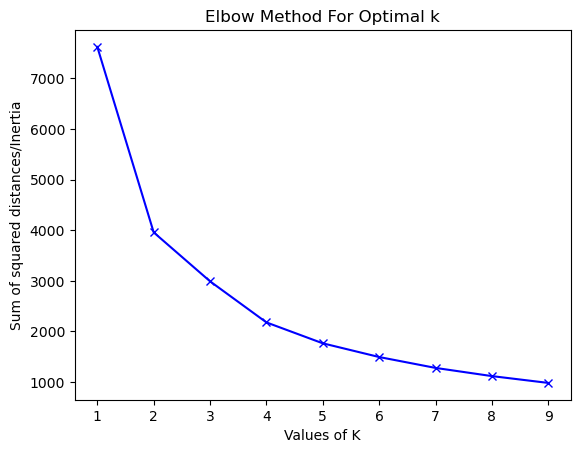

In [768]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_treated[['PCA1', 'PCA2']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

c:\Users\pcday\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


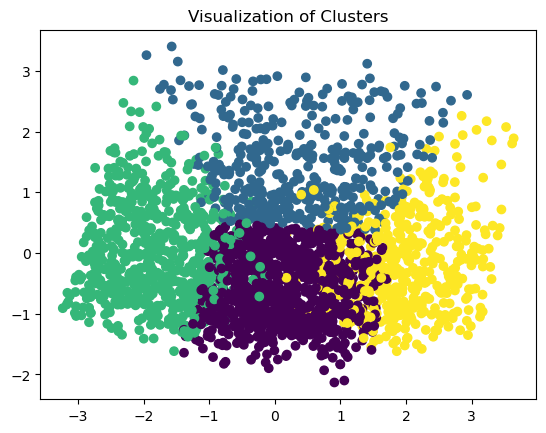

In [769]:
kmeans = KMeans(n_clusters=4)  # Use the optimal_k obtained from the elbow method
kmeans.fit(scaled_data)

# Add the cluster labels to the DataFrame
df_treated['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.scatter(df_treated['PCA1'], df_treated['PCA2'], c=df_treated['Cluster'], cmap='viridis')
plt.title('Visualization of Clusters')
plt.show()

In [853]:
from pyecharts import options as opts
from pyecharts.charts import Scatter

# Define colors for each cluster
cluster_colors = {
    0: '#ff7f0e',  # Cluster 0 color
    1: '#1f77b4',  # Cluster 1 color
    2: '#2ca02c',  # Cluster 2 color
    3: '#d62728',  # Cluster 3 color
}

scatter = Scatter()

for cluster_id, color in cluster_colors.items():
    # Filter data for each cluster
    cluster_data = df_treated[df_treated['Cluster'] == cluster_id]
    # Extract PCA1 and PCA2 values for the cluster
    x_data = round(cluster_data['PCA1'], 2).tolist()
    y_data = round(cluster_data['PCA2'], 2).tolist()
    # Add scatter data for the cluster
    scatter.add_xaxis(x_data)
    scatter.add_yaxis(
        series_name=f'Cluster {cluster_id}',
        y_axis=y_data,
        symbol_size=8,
        label_opts=opts.LabelOpts(is_show=False),
        itemstyle_opts=opts.ItemStyleOpts(color=color),
    )

scatter.set_global_opts(
    title_opts=opts.TitleOpts(title="Visualization of Clusters"),
    xaxis_opts=opts.AxisOpts(type_="value"),
    yaxis_opts=opts.AxisOpts(type_="value"),
    axispointer_opts=opts.AxisLineOpts(is_show= True),

)

scatter.render("scatter_with_clusters.html")

'c:\\Users\\pcday\\Documents\\Repository\\Python Notebooks\\scatter_with_clusters.html'

In [770]:
df_treated['Cluster'].value_counts()

Cluster
0    882
2    667
3    460
1    395
Name: count, dtype: int64

In [771]:
end_date_cal

datetime.date(2011, 9, 27)

In [772]:
merged_df = df_clients.merge(df_treated.reset_index()[['CustomerID', 'Cluster']], on = 'CustomerID', how = 'left')
merged_df.dropna(subset=['Cluster'], inplace=True)
merged_df['Cluster'] = merged_df['Cluster'].astype('int')
merged_df = merged_df[(merged_df['InvoiceDate'] > '2011-09-26') & (merged_df['InvoiceDate'] < '2011-10-27')]
merged_df

,CustomerID,InvoiceNo,InvoiceDate,Period,Monetary,Cluster
20,12352,568699,2011-09-28,Afternoon,266.25,3
37,12360,571705,2011-10-18,Afternoon,1043.78,1
43,12362,568651,2011-09-28,Day,829.99,3
44,12362,570667,2011-10-11,Afternoon,355.80,3
45,12362,572887,2011-10-26,Afternoon,786.95,3
...,...,...,...,...,...,...
18476,18257,569358,2011-10-03,Afternoon,517.53,3
18477,18257,569359,2011-10-03,Afternoon,14.85,3
18495,18265,568680,2011-09-28,Afternoon,312.96,2
18504,18272,572617,2011-10-25,Day,604.25,1


In [780]:
df_treated.groupby('Cluster')['CLV'].sum().reset_index()

,Cluster,CLV
0,0,64308.750425
1,1,68538.440014
2,2,94763.359299
3,3,91529.946592


In [779]:
merged_df.groupby(['Cluster'])['Monetary'].sum().reset_index()

,Cluster,Monetary
0,0,63520.65
1,1,94977.86
2,2,107990.11
3,3,118641.97


In [778]:
merged_df.groupby(['Cluster', 'Period'])['Monetary'].sum().reset_index()

,Cluster,Period,Monetary
0,0,Day,29300.45
1,0,Afternoon,34220.20
2,0,Night,0.00
3,1,Day,45551.81
4,1,Afternoon,48637.94
5,1,Night,788.11
6,2,Day,53551.97
7,2,Afternoon,54438.14
8,2,Night,0.00
9,3,Day,63157.13
